# Titanic Predict with Pipeline
---  

# 1. Import Libraries & Load Data

In [3]:
## EDA Standard Libary

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats as ss

In [4]:
#ML Library

#ML Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
#ML TrainTest Split
from sklearn.model_selection import train_test_split
#ML Report
from sklearn.metrics import  accuracy_score, classification_report

In [5]:
#Load Data
df = sns.load_dataset('titanic')
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


# 2. Data Cleaning

In [6]:
#Construct deep Info on columns & values:

datainfo = []
for i in df.columns:
    datainfo.append([i, df[i].dtypes,
                      df[i].isna().sum(),
                      round((((df[i].isna().sum())/(len(df)))*100),2), 
                    df[i].nunique(), 
                    df[i].sample(3).values])
pd.DataFrame(datainfo, columns = ['dataFeatures', 'dataType', 'null', 'nullPct', 'unique','uniqueSample'])


,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,survived,int64,0,0.00,2,"[0, 1, 1]"
1,pclass,int64,0,0.00,3,"[3, 3, 2]"
2,sex,object,0,0.00,2,"[female, female, female]"
3,age,float64,177,19.87,88,"[50.0, 25.0, 26.0]"
4,sibsp,int64,0,0.00,7,"[0, 1, 0]"
5,parch,int64,0,0.00,7,"[0, 1, 0]"
6,fare,float64,0,0.00,248,"[110.8833, 76.7292, 39.6875]"
7,embarked,object,2,0.22,3,"[Q, Q, S]"
8,class,category,0,0.00,3,"['Third', 'First', 'First'] Categories (3, obj..."
9,who,object,0,0.00,3,"[woman, woman, woman]"


In [7]:
df[['pclass', 'class', 'fare']]

,pclass,class,fare
0,3,Third,7.2500
1,1,First,71.2833
2,3,Third,7.9250
3,1,First,53.1000
4,3,Third,8.0500
...,...,...,...
886,2,Second,13.0000
887,1,First,30.0000
888,3,Third,23.4500
889,1,First,30.0000


Can't use ordinal on class, because it's not ordinal, it's categorical

## 2.1 Drop Columns

In [8]:
#Unused Data
df.drop(['deck','alive','class','who','adult_male','alone','embark_town'], axis=1, inplace=True)

## 2.2 Fill Age with Median

In [9]:
# Fill Missing Values with median
df['age'].fillna(df['age'].median(), inplace=True)  

## 2.3 Drop Rows with Missing Values

In [10]:
#Drop Null
df.dropna(inplace=True)

## 2.4 Handle Outliers

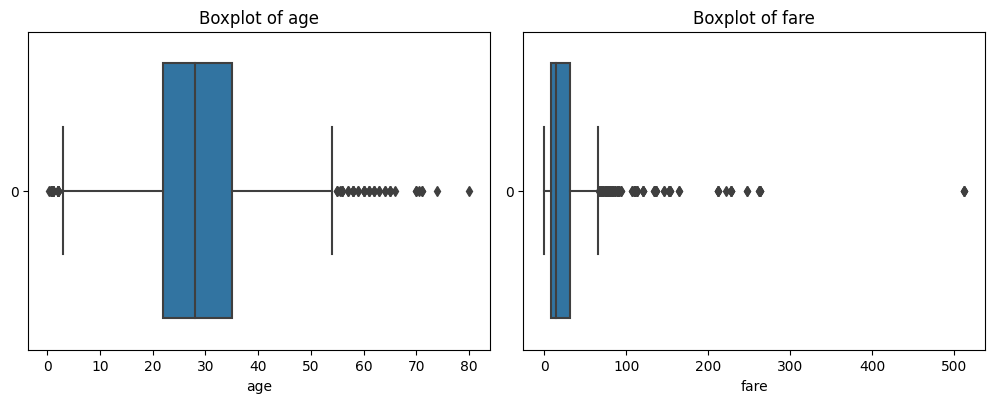

In [11]:
#Numerical columns
numerical_cols = ['age', 'fare']

# Plotting boxplot for numerical values 
plt.figure(figsize=(15, 15))
for i, column in enumerate(numerical_cols, 1):
    plt.subplot(4, 3, i)
    sns.boxplot(data=df[column], orient='horizontal')
    plt.title(f'Boxplot of {column}')
    plt.xlabel(column)
    
plt.tight_layout()
plt.show()

Dropping outliers on fare

In [12]:
# Drop outliers
df.drop(df[df['fare'] > 300].index, inplace=True)

In [13]:
#Reset Index
df.reset_index(drop=True, inplace=True)

# 3. Feature Engineering

## 3.1 Select Target & Features

In [14]:
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [15]:
# Target Variable
y = df['survived']

# Feature Variables
x = df.drop(['survived'], axis=1)

## 3.2 Train Test Split

In [16]:
#Train test split

xtrain, xtest, ytrain, ytest = train_test_split(
    x,
    y,
    test_size= 0.2,    # Test Data Size as 20% 
    random_state=20,   # Random seed
    stratify=y         # Proportion between train & test, same propotion as y 
)

## 3.3 Preprocessing Schema

| Process | Column |
| --- | --- |
| OHE | 'pclass', 'sex', 'embarked'| 
| RobustScaler | 'age', 'fare' |


In [17]:
#Import library for preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer


In [18]:
# Build transformer
transform = ColumnTransformer([
    ('OHE', OneHotEncoder(drop='first'), ['pclass', 'sex', 'embarked']),
    ('Robust Scaler', RobustScaler(), ['age', 'fare'])], remainder='passthrough')
transform

ColumnTransformer(remainder='passthrough',
                  transformers=[('OHE', OneHotEncoder(drop='first'),
                                 ['pclass', 'sex', 'embarked']),
                                ('Robust Scaler', RobustScaler(),
                                 ['age', 'fare'])])

# 4. Modeling 

## 4.1 Create Pipeline

In [19]:
#Model: Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(
    max_depth=5,
    criterion='entropy',
)

In [20]:
from sklearn.pipeline import Pipeline as pipeline

# Construct Preprocessing & Model Pipeline

pipe = pipeline([
    ('Preprocess', transform),
    ('DT Classifier', dt)])
pipe

Pipeline(steps=[('Preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('OHE',
                                                  OneHotEncoder(drop='first'),
                                                  ['pclass', 'sex',
                                                   'embarked']),
                                                 ('Robust Scaler',
                                                  RobustScaler(),
                                                  ['age', 'fare'])])),
                ('DT Classifier',
                 DecisionTreeClassifier(criterion='entropy', max_depth=5))])

## 4.2 Fit Pipeline to Train Data

In [21]:
# Fit Pipeline
pipe.fit(xtrain, ytrain)

Pipeline(steps=[('Preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('OHE',
                                                  OneHotEncoder(drop='first'),
                                                  ['pclass', 'sex',
                                                   'embarked']),
                                                 ('Robust Scaler',
                                                  RobustScaler(),
                                                  ['age', 'fare'])])),
                ('DT Classifier',
                 DecisionTreeClassifier(criterion='entropy', max_depth=5))])

## 4.3 Apply Model to Test Data

In [22]:
pipe.predict(xtest)

array([1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 1])

In [41]:
# pclass_in = input('pclass = ')
# sex = male
# age = 10 
# fare = 10
# parch = 
# sibsp = 1
# rmbarked = C
# parch = 0

In [44]:
import pandas as pd

data = {'pclass': [0], 'sex': ['male'], 'age': [10], 'fare': [10], 'parch': [0], 'sibsp': [0], 'embarked': ['C']}
new_df = pd.DataFrame(data)
new_df

,pclass,sex,age,fare,parch,sibsp,embarked
0,3,male,10,10,0,0,C


In [45]:
pipe.predict(new_df)

array([0])

# 5. Evaluate Model

In [23]:
print(f' Accuracy score for train data: {pipe.score(xtrain, ytrain)} ')
print(f' Accuracy score for test data: {pipe.score(xtest, ytest)} ')

 Accuracy score for train data: 0.8573446327683616 
 Accuracy score for test data: 0.8033707865168539 


In [24]:
#Train Data classification report
print(classification_report(ytrain, pipe.predict(xtrain)))

              precision    recall  f1-score   support

           0       0.86      0.92      0.89       439
           1       0.86      0.75      0.80       269

    accuracy                           0.86       708
   macro avg       0.86      0.84      0.84       708
weighted avg       0.86      0.86      0.86       708



In [25]:
# Test Data classification report
print(classification_report(ytest, pipe.predict(xtest)))

              precision    recall  f1-score   support

           0       0.80      0.91      0.85       110
           1       0.81      0.63      0.71        68

    accuracy                           0.80       178
   macro avg       0.81      0.77      0.78       178
weighted avg       0.80      0.80      0.80       178



In [26]:
# Accuracy score for train
accuracy_score(ytrain, pipe.predict(xtrain))

0.8573446327683616

In [27]:
#Accuracy score for test
accuracy_score(ytest, pipe.predict(xtest))

0.8033707865168539